In [30]:
#Import des librairies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import seaborn as sns
import scipy.stats as st
from sklearn.linear_model import LinearRegression
%matplotlib inline

In [31]:
#import des données
data = pd.read_csv('données/P4_03_transactions_clean.csv', encoding ='UTF_8')
transactions = data.copy()

In [32]:
#Attribution de variables aux noms des colonnes dans un soucis de maintenance
client_id = 'client_id'
sex = 'sex'
birth = 'birth'
id_prod = 'id_prod'
price = 'price'
categ = 'categ'
date = 'date'
session_id = 'session_id'

# Mission 2

## Indicateurs de tendance centrale et de dispersion 

### Moyenne, écart-type, quartiles, min, median et max des montants de ventes

In [33]:
transactions[price].describe()

count    336713.000000
mean         17.215189
std          17.855445
min           0.620000
25%           8.610000
50%          13.900000
75%          18.990000
max         300.000000
Name: price, dtype: float64

### Moyenne, écart-type, quartiles, min, median et max de l'age des clients 

In [34]:
transactions['age'] = datetime.datetime.now().year - transactions[birth]
transactions['age'].describe()

count    336713.000000
mean         43.176432
std          13.524433
min          17.000000
25%          34.000000
50%          41.000000
75%          50.000000
max          92.000000
Name: age, dtype: float64

## Analyse de concentration, via une courbe de Lorenz et un indice de Gini

In [35]:
#On affiche les statistiques élémentaires concernant les montants des transactions
transactions[price].describe()

count    336713.000000
mean         17.215189
std          17.855445
min           0.620000
25%           8.610000
50%          13.900000
75%          18.990000
max         300.000000
Name: price, dtype: float64

In [36]:
# Création d'un dataframe pour afficcher la courbe de Lorenz
def courbe_lorenz(data) :
    data = data.groupby(client_id).sum(price).sort_values(price).reset_index()
    part_client = int(len(data)/10)
    tab = []
    pourcent = 0
    for i in range(0, int(len(data) + 1), part_client) :
        data_i = data[data.index < i]
        montant = data_i[price].sum()
        montant = round( montant / data[price].sum() * 100, 2)
        tab.append([pourcent, montant])
        pourcent += 10
    data_lorenz = pd.DataFrame(tab, columns = ['% des clients', '% Montant'])
    return data_lorenz

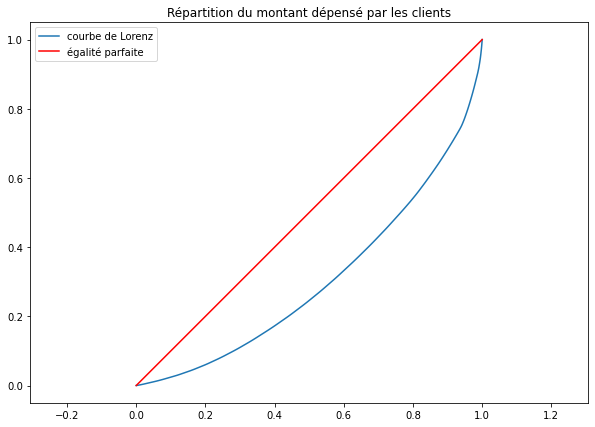

In [37]:
depenses = transactions[transactions[price] > 0]
dep = +depenses[price].values
n = len(dep)
lorenz1 = np.cumsum(np.sort(dep)) / dep.sum()
lorenz1 = np.append([0],lorenz1) # La courbe de Lorenz commence à 0
fig = plt.figure(figsize=(10,7))
plt.axes().axis('equal')
plt.title('Répartition du montant dépensé par les clients')
xaxis = np.linspace(0-1/n,1+1/n,n+1) #Il y a un segment de taille n pour chaque individu, plus 1 segment supplémentaire d'ordonnée 0. Le premier segment commence à 0-1/n, et le dernier termine à 1+1/n.
plt.plot(xaxis,lorenz1,drawstyle='steps-post', label = "courbe de Lorenz")
a = [0,1]
b = a
plt.plot(a, b, c='r', label = 'égalité parfaite')
plt.legend()
plt.savefig('graphiques/P4_04_courbe_lorenz.png')
plt.show()

In [38]:
#Calcul du coefficient de Gini
def gini(lorenz) :
    old_x = 0
    old_y = 0
    gini = 0
    B = 0
    for index, row in lorenz.iterrows() :
        x = row['% des clients'] / 100
        y = row['% Montant'] / 100
        
        base = x - old_x
        hauteur = y - old_y
        
        aire_triangle = base * hauteur / 2
        aire_rectangle = base * old_y
        
        B += aire_triangle + aire_rectangle
        
        old_x = x
        old_y = y
    A = 1 * 1 / 2
    gini = 2 * (A - B)
    return gini

In [39]:
lorenz = courbe_lorenz(transactions)
gini(lorenz)

0.42706

## Représentations graphiques

### Histogramme

#### Nombre de ventes par catégories 

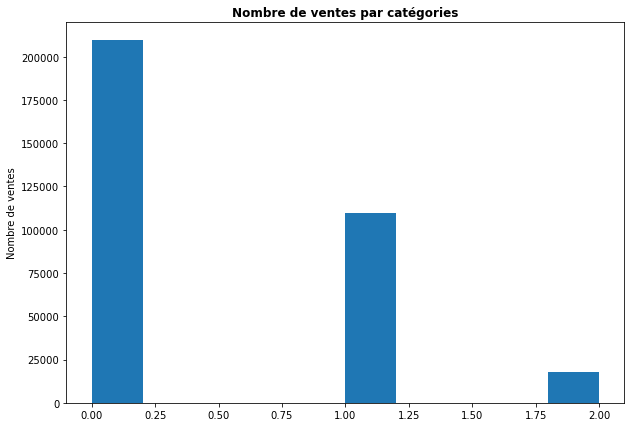

In [40]:
fig = plt.figure(figsize =(10,7))
plt.title('Nombre de ventes par catégories', fontweight = 'bold')
plt.ylabel('Nombre de ventes')
plt.hist(transactions[categ])
plt.savefig('graphiques/P4_04_montant_vente_categorie_histo.png')
plt.show()

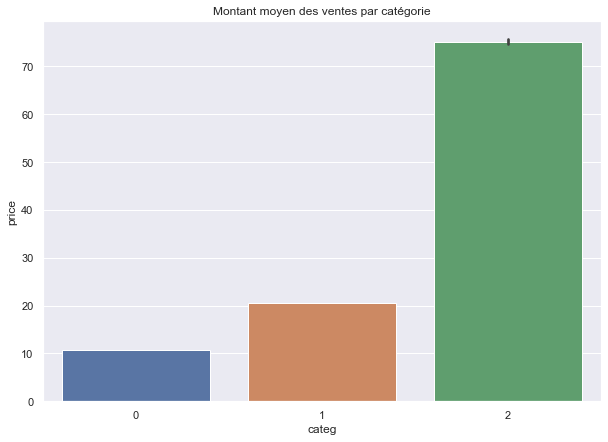

In [41]:
sns.set(rc = {'figure.figsize': (10, 7)})
sns.barplot(x = categ, y = price, data = transactions).set(title = 'Montant moyen des ventes par catégorie')
plt.savefig('graphiques/P4_04_montant_vente_categorie_barplot.png')

### Boîtes à moustaches

#### Age des clients 

In [42]:
#On calcul l'age de nos clients pour simplifier notre analyse
client_age = transactions.copy()
client_age = client_age.drop([id_prod, date, session_id, client_id, sex, price, categ], axis=1)
client_age['age'] = datetime.datetime.now().year - client_age[birth]

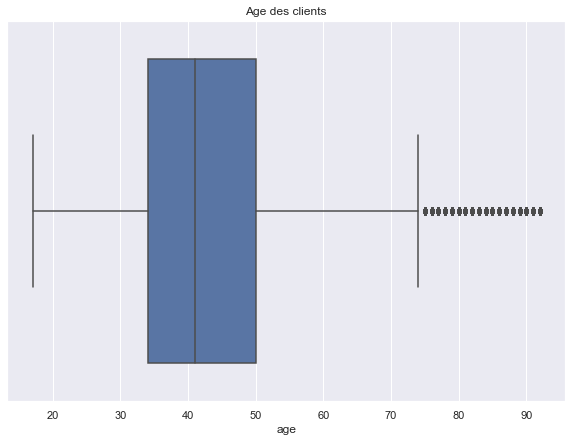

In [43]:
#On crée une boxplot pour avoir une visualisation des données concernant les années de naissance de nos clients
sns.boxplot(x = 'age', data = transactions).set(title = 'Age des clients')
plt.savefig('graphiques/P4_04_age_clients.png')

In [44]:
#On affiche également, les statistiques élémentaires concernant l'age de nos clients 
client_age.describe()

Unnamed: 0          birth            age
count  336713.000000  336713.000000  336713.000000
mean   168458.747194    1977.823568      43.176432
std     97250.489161      13.524433      13.524433
min         0.000000    1929.000000      17.000000
25%     84236.000000    1971.000000      34.000000
50%    168471.000000    1980.000000      41.000000
75%    252678.000000    1987.000000      50.000000
max    336889.000000    2004.000000      92.000000

In [45]:
#Détection des outliers gràce à la loi interquartile
q1 = client_age['age'].quantile(0.25)
q3 = client_age['age'].quantile(0.75)
iqr = q3 - q1
iqr

16.0

In [46]:
#On calcul la limite admissible de nos âges, la valeur minimale obtenue n'étant pas pertinente dans le contexte de notre analyse 
#nous ne tiendrons compte que de la valeur maximale.
age_limit_min = q1 - 1.5 * iqr
age_limit_max = q3 + 1.5 * iqr
age_limit_max

74.0

#### Montants des transactions

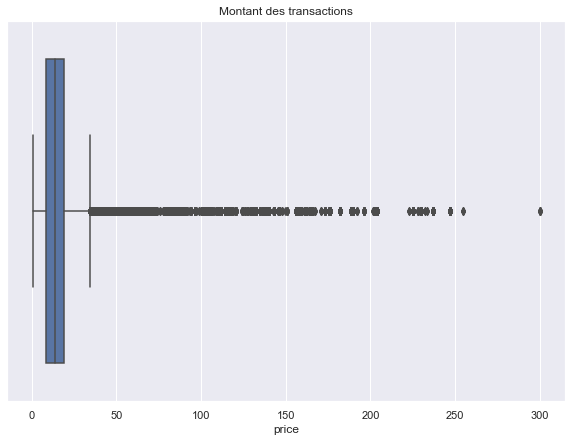

In [47]:
#On crée une boxplot pour avoir une visualisation des données concernant les montants des transactions
sns.boxplot(x = transactions[price]).set(title = 'Montant des transactions')
plt.savefig('graphiques/P4_04_montant_transactions.png')

In [48]:
#On affiche les statistiques élémentaires concernant les montants des transactions
transactions[price].describe()

count    336713.000000
mean         17.215189
std          17.855445
min           0.620000
25%           8.610000
50%          13.900000
75%          18.990000
max         300.000000
Name: price, dtype: float64

In [49]:
#Detection des outliers en appliquant la loi interquartile
q1 = transactions[price].quantile(0.25)
q3 = transactions[price].quantile(0.75)
iqr = q3 - q1
iqr

10.379999999999999

In [50]:
#Calcul de la limite basse d'un montant à partir duquel on le considère comme outlier
price_limit_min = q1 - 1.5 * iqr
price_limit_min
#La valeur ne sera pas prise en compte car aberrante dans le contexte d'une vente

-6.959999999999999

In [51]:
#Calcul de la limite haute d'un montant à partir duquel on le considère commme outlier
price_limit_max = q3 + 1.5 * iqr
price_limit_max

34.559999999999995

### Représentation de série temporelle

#### Ventes par mois 

In [52]:
#Vérification de la cohérence des dates
transactions[date] = pd.to_datetime(transactions[date])
mask1 = transactions[date] <= datetime.datetime.now()
transactions.shape

(336713, 10)

In [53]:
#On retire les dates incohérentes
transactions_now = transactions[mask1].reset_index()
transactions_now.shape

(208268, 11)

In [54]:
#On regarde la date de l'individu le plus ancien de notre population
transactions_now[date].min()

Timestamp('2021-03-01 00:01:07.843138')

In [55]:
#Préparation des données pour l'analyse graphique
transactions_mois = transactions.copy()
transactions_mois[date] = transactions_mois[date].dt.strftime('%Y/%m')
transactions_mois = transactions_mois[[date, price]].groupby(date).count().sort_values(date).reset_index()
transactions_mois.head()

date  price
0  2021/03  28559
1  2021/04  28401
2  2021/05  28237
3  2021/06  26812
4  2021/07  24712

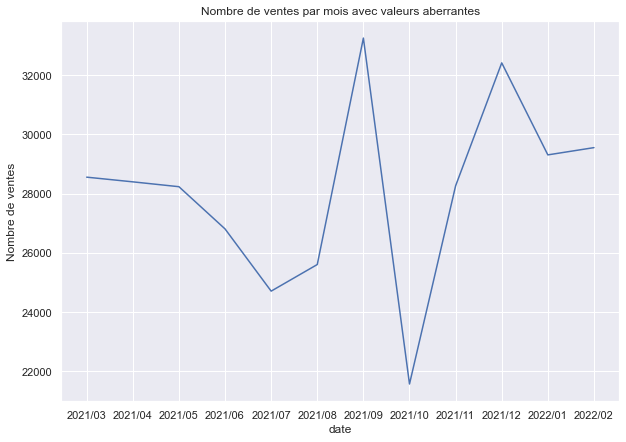

In [56]:
sns.lineplot(x = date, y = price, data = transactions_mois).set(title = 'Nombre de ventes par mois avec valeurs aberrantes', ylabel = 'Nombre de ventes')
plt.savefig('graphiques/P4_04_nb_ventes_par_mois_avec_valeur_aberrantes.png')

In [57]:
transactions_mois = transactions_now.copy()
transactions_mois[date] = transactions_mois[date].dt.strftime('%Y/%m')
transactions_mois = transactions_mois[[date, price]].groupby(date).count().sort_values(date).reset_index()
transactions_mois.head()

date  price
0  2021/03  28559
1  2021/04  28401
2  2021/05  28237
3  2021/06  26812
4  2021/07  24712

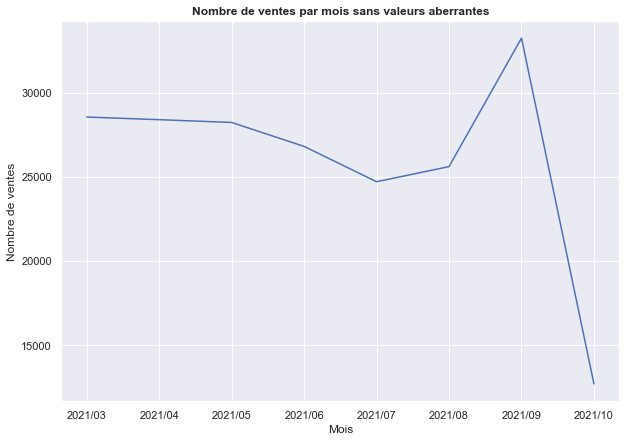

In [58]:
# On affiche le nombre de ventes par mois
fig = plt.figure(figsize=(10,7))
plt.title('Nombre de ventes par mois sans valeurs aberrantes', fontweight = 'bold')
plt.xlabel('Mois')
plt.ylabel('Nombre de ventes')
plt.plot(transactions_mois[date], transactions_mois[price])

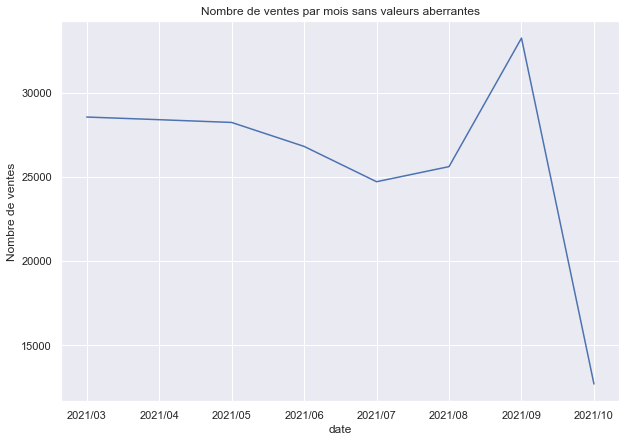

In [59]:
sns.set(rc = {'figure.figsize': (10, 7)})
sns.lineplot(x = date, y = price, data = transactions_mois).set(title = 'Nombre de ventes par mois sans valeurs aberrantes', ylabel = 'Nombre de ventes')
plt.savefig('graphiques/P4_04_Nombre_de_ventes_par_mois_sans_valeurs_aberrantes.png')

#### Ventes du dernier mois 

In [60]:
#Préparation des données pour l'analyse graphique
transactions_day = transactions.copy()
transactions_day[date] = transactions_day[date].dt.strftime('%Y%m%d')
transactions_day[date] = pd.to_datetime(transactions_day[date])
mask1 = transactions_day[date].dt.month == datetime.datetime.now().month
transactions_day = transactions_day[mask1]
transactions_day_count = transactions_day[date].value_counts().reset_index()
transactions_day_count = transactions_day_count.sort_values(by = 'index')
transactions_day_count = transactions_day_count.set_index('index')
transactions_day_count.describe()

date
count    31.000000
mean    696.032258
std     122.201332
min     577.000000
25%     626.000000
50%     661.000000
75%     696.500000
max    1043.000000

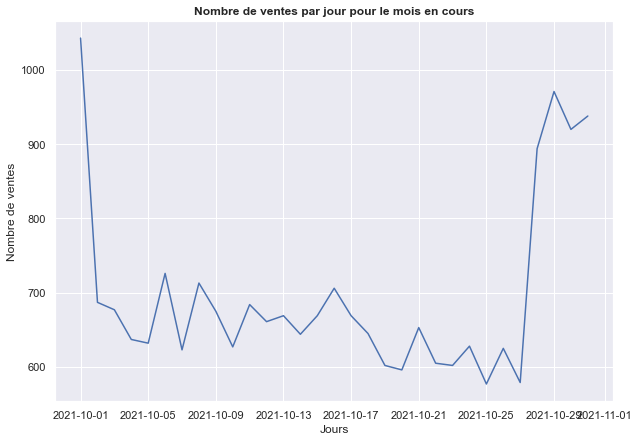

In [61]:
# On affiche le nombre de ventes par jour pour le mois en cours
fig = plt.figure(figsize=(10,7))
plt.title('Nombre de ventes par jour pour le mois en cours', fontweight = 'bold')
plt.xlabel('Jours')
plt.ylabel('Nombre de ventes')
plt.plot(transactions_day_count.index, transactions_day_count)
plt.savefig('graphiques/P4_04_Nombre_de_ventes_par_jour_dernier_mois.png')

#### Répartition des ventes dans la semaine 

In [62]:
#Préparation des données pour l'analyse graphique
transactions_week = transactions.copy()
transactions_week = transactions_week[date].dt.strftime('%A')
transactions_week.describe()

count     336713
unique         7
top       Monday
freq       48809
Name: date, dtype: object

In [63]:
week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
transactions_week_count = transactions_week.value_counts().reindex(week)
transactions_week_count

Monday       48809
Tuesday      47717
Wednesday    47853
Thursday     48428
Friday       48329
Saturday     47767
Sunday       47810
Name: date, dtype: int64

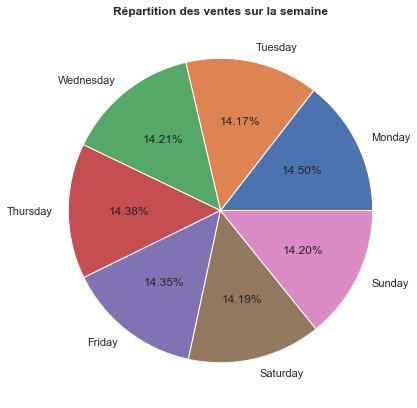

In [64]:
fig = plt.figure(figsize = (10, 7))
plt.title('Répartition des ventes sur la semaine', fontweight = 'bold')
plt.pie(transactions_week_count, labels = transactions_week_count.index, autopct = "%0.2f%%")
plt.savefig('graphiques/P4_04_Nombre_de_ventes_par_jour_semaine.png')
plt.show()

###  Montant des ventes par mois et par catégorie

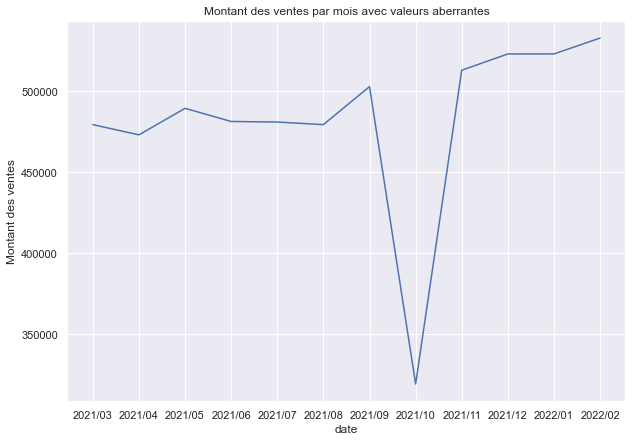

In [65]:
#Préparation des données pour l'analyse graphique
montant_mois = transactions.copy()
montant_mois[date] = montant_mois[date].dt.strftime('%Y/%m')
montant_mois = montant_mois[[date, price]].groupby(date).sum().sort_values(date).reset_index()
sns.lineplot(x = date, y = price, data = montant_mois).set(title = 'Montant des ventes par mois avec valeurs aberrantes', ylabel = 'Montant des ventes')
plt.savefig('graphiques/P4_04_evolution_chiffre_affaire.png')

In [66]:
montant_mois_bug = transactions.copy()
montant_mois_bug = montant_mois_bug[montant_mois_bug[date] > datetime.datetime.now()]
montant_mois_bug = montant_mois_bug[price].sum()
print('Montant total des ventes concernées par un bug de date :',round(montant_mois_bug, 2), '€')

Montant total des ventes concernées par un bug de date : 2231502.23 €


In [67]:
ca_mois_courant = transactions.copy()
ca_mois_courant['annee'] = ca_mois_courant[date].dt.strftime('%Y')
ca_mois_courant['mois'] = ca_mois_courant[date].dt.strftime('%m')
ca_mois_courant['annee'] = ca_mois_courant['annee'].astype(int)
ca_mois_courant['mois'] = ca_mois_courant['mois'].astype(int)
mask1 = ca_mois_courant['annee'] == datetime.datetime.now().year
mask2 = ca_mois_courant['mois'] == datetime.datetime.now().month - 1
ca_mois_courant = ca_mois_courant[ mask1 & mask2]
print("Chiffre d'affaire du dernier mois :",ca_mois_courant.price.sum(),'€')

Chiffre d'affaire du dernier mois : 502771.2800000001 €


## Analyses bivariées

#### Nombre de produits achetés par client par catégories

In [68]:
cat_moy_achat = transactions.copy()
cat_moy_achat = cat_moy_achat[[categ, client_id, price]]
cat_moy_achat = cat_moy_achat.groupby([categ, client_id]).count().reset_index()
cat_moy_achat = cat_moy_achat.rename(columns = {price : "Nombre de produits achetés par client"})
cat_moy_achat.describe()

categ  Nombre de produits achetés par client
count  19609.000000                            19609.00000
mean       0.765006                               17.17135
std        0.716747                               84.10610
min        0.000000                                1.00000
25%        0.000000                                4.00000
50%        1.000000                                9.00000
75%        1.000000                               19.00000
max        2.000000                            10286.00000

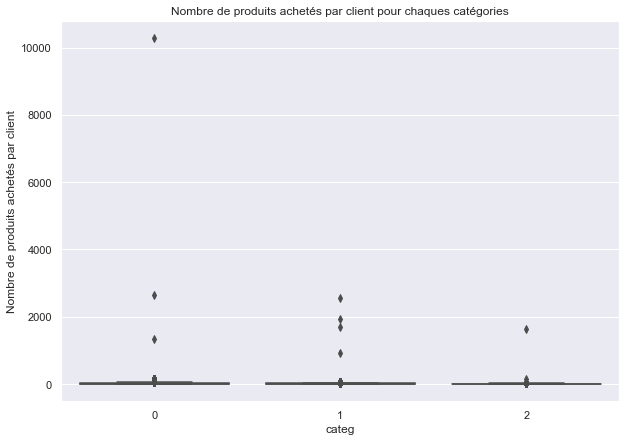

In [69]:
sns.boxplot(x = categ, y = "Nombre de produits achetés par client", data = cat_moy_achat).set(title = "Nombre de produits achetés par client pour chaques catégories")
plt.savefig('graphiques/P4_04_nb_prod_par_client_par_catégorie_avec_outliers.png')

In [70]:
#Méthode des moindres carrés
X = categ # qualitative
Y = "Nombre de produits achetés par client" # quantitative

sous_echantillon = cat_moy_achat[cat_moy_achat["Nombre de produits achetés par client"] > 0] # On ne garde que les categories 1 et 2

def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT
    
eta_squared(sous_echantillon[X],sous_echantillon[Y])

0.009381994755274363

In [71]:
st.f_oneway(cat_moy_achat["Nombre de produits achetés par client"], cat_moy_achat[categ])

F_onewayResult(statistic=746.0922846954797, pvalue=9.529148657137018e-163)

In [72]:
#Détection des outliers gràce à la loi interquartile
q1 = cat_moy_achat["Nombre de produits achetés par client"].quantile(0.25)
q3 = cat_moy_achat["Nombre de produits achetés par client"].quantile(0.75)
iqr = q3 - q1

cat_moy_achat_min = q1 - 1.5 * iqr
cat_moy_achat_max = q3 + 1.5 * iqr
cat_moy_achat = cat_moy_achat[cat_moy_achat["Nombre de produits achetés par client"] < cat_moy_achat_max]
cat_moy_achat = cat_moy_achat[cat_moy_achat["Nombre de produits achetés par client"] > cat_moy_achat_min]

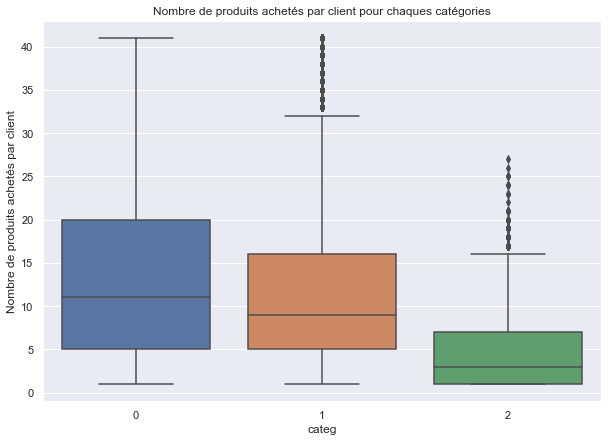

In [73]:
sns.boxplot(x = categ, y = "Nombre de produits achetés par client", data = cat_moy_achat).set(title = "Nombre de produits achetés par client pour chaques catégories")
plt.savefig('graphiques/P4_04_nb_prod_par_client_par_catégorie_sans_outliers.png')

In [74]:
#Méthode des moindres carrés
X = categ # qualitative
Y = "Nombre de produits achetés par client" # quantitative

sous_echantillon = cat_moy_achat[cat_moy_achat["Nombre de produits achetés par client"] > 0] # On ne garde que les categories 1 et 2
    
eta_squared(sous_echantillon[X],sous_echantillon[Y])

0.10587234552429822

In [75]:
st.f_oneway(cat_moy_achat["Nombre de produits achetés par client"], cat_moy_achat[categ])

F_onewayResult(statistic=21588.195283565055, pvalue=0.0)

#### Montant dépensé par client et par catégories

In [76]:
cat_montant_achat = transactions.copy()
cat_montant_achat = cat_montant_achat[[categ, client_id, price]]
cat_montant_achat = cat_montant_achat.groupby([categ, client_id]).sum(price).reset_index()
cat_montant_achat = cat_montant_achat.rename(columns = {price : "Montant dépensé par client"})
cat_montant_achat.describe()

categ  Montant dépensé par client
count  19609.000000                19609.000000
mean       0.765006                  295.608025
std        0.716747                 1353.831485
min        0.000000                    3.030000
25%        0.000000                   82.680000
50%        1.000000                  176.180000
75%        1.000000                  363.320000
max        2.000000               125206.730000

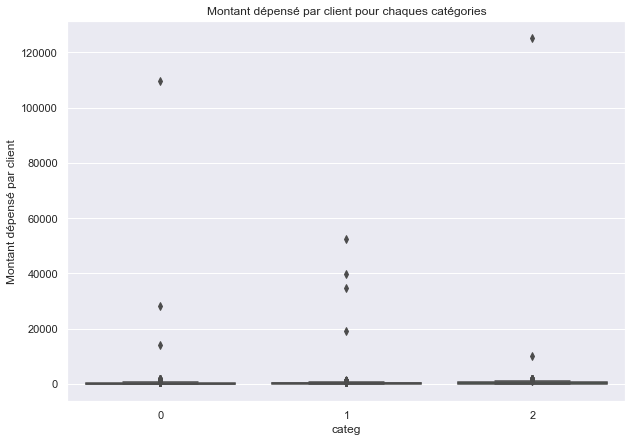

In [77]:
sns.boxplot(x = categ, y = "Montant dépensé par client", data = cat_montant_achat).set(title = "Montant dépensé par client pour chaques catégories")
plt.savefig('graphiques/P4_04_montant_par_client_par_catégorie_avec_outliers.png')

In [78]:
#Méthode des moindres carrés
X = categ # qualitative
Y = "Montant dépensé par client" # quantitative

sous_echantillon = cat_montant_achat[cat_montant_achat["Montant dépensé par client"] > 0] # On ne garde que les categories 1 et 2

eta_squared(sous_echantillon[X],sous_echantillon[Y])

0.001294459941205966

In [79]:
st.f_oneway(cat_montant_achat["Montant dépensé par client"], cat_montant_achat[categ])

F_onewayResult(statistic=930.0532299584182, pvalue=6.62906181656795e-202)

In [80]:
#Détection des outliers gràce à la loi interquartile
q1 = cat_montant_achat["Montant dépensé par client"].quantile(0.25)
q3 = cat_montant_achat["Montant dépensé par client"].quantile(0.75)
iqr = q3 - q1

cat_montant_achat_min = q1 - 1.5 * iqr
cat_montant_achat_max = q3 + 1.5 * iqr
cat_montant_achat = cat_montant_achat[cat_montant_achat["Montant dépensé par client"] < cat_montant_achat_max]
cat_montant_achat = cat_montant_achat[cat_montant_achat["Montant dépensé par client"] > cat_montant_achat_min]

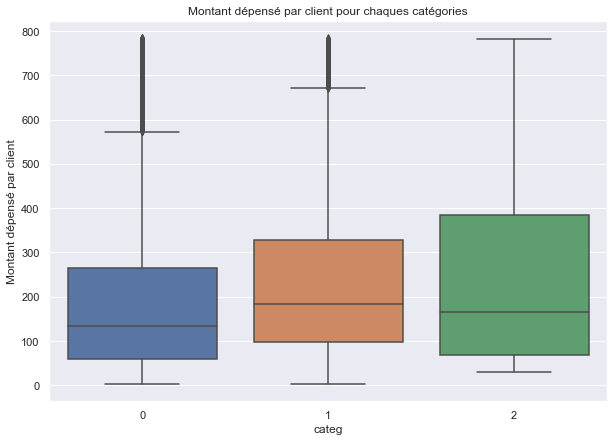

In [81]:
sns.boxplot(x = categ, y = "Montant dépensé par client", data = cat_montant_achat).set(title = "Montant dépensé par client pour chaques catégories")
plt.savefig('graphiques/P4_04_montant_par_client_par_catégorie_sans_outliers.png')
plt.show()

In [82]:
#Méthode des moindres carrés
X = categ # qualitative
Y = "Montant dépensé par client" # quantitative

sous_echantillon = cat_montant_achat[cat_montant_achat["Montant dépensé par client"] > 0] # On ne garde que les categories 1 et 2

eta_squared(sous_echantillon[X],sous_echantillon[Y])

0.014872748446321419

In [83]:
st.f_oneway(cat_montant_achat["Montant dépensé par client"], cat_montant_achat[categ])

F_onewayResult(statistic=25914.703091977273, pvalue=0.0)

#### Chiffre d'affaire par tranche d'age

In [84]:
#création de tranche d'ages
age_ca = transactions.copy()
age_ca["Tranche d'ages"] = pd.cut(age_ca['age'], bins=[16,30,50,93], labels=['17-30 ans ', '30-50 ans ', '50-93ans'])
age_ca = age_ca[["Tranche d'ages", price]]
age_ca = age_ca.groupby("Tranche d'ages").sum(price).reset_index()

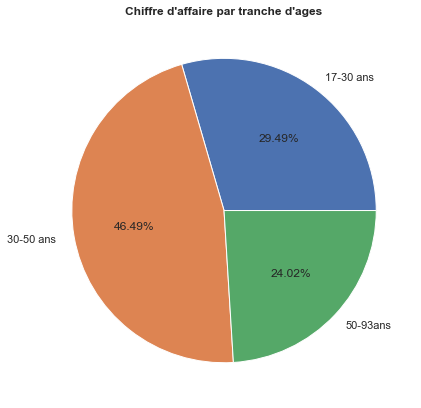

In [85]:
fig = plt.figure(figsize = (10, 7))
plt.title("Chiffre d'affaire par tranche d'ages", fontweight = 'bold')
plt.pie(age_ca[price], labels = age_ca["Tranche d'ages"].values, autopct = "%0.2f%%")
plt.savefig('graphiques/P4_04_ca_par_tranche_age.png')
plt.show()

## Mission 3

#### Montant/age 

In [86]:
montant_age = transactions.copy()
montant_age = montant_age.groupby('age').sum(price).reset_index()
montant_age = montant_age[['age', price]]
montant_age.describe()

age          price
count  76.000000      76.000000
mean   54.500000   76270.760132
std    22.083176   64564.596652
min    17.000000    1300.030000
25%    35.750000   18650.327500
50%    54.500000   71023.585000
75%    73.250000  116093.952500
max    92.000000  306050.840000

In [87]:
#Calcul de a, b et du coefficient de corrélation avec scipy.stats
a, b, r, _, _ = st.linregress(montant_age['age'].values, montant_age[price].values)
print('a =', a, 'b =', b, 'r = ',r)

a = -2264.86835475054 b = 199706.0854654846 r =  -0.7746580837682122


In [88]:
#On instancie le model
model_linReg = LinearRegression()
x = montant_age.iloc[:, 0].values
x = x.reshape(-1, 1)
y = montant_age.iloc[:, 1].values
y = y.reshape(-1, 1)
#entrainement du modèle
model_linReg.fit(x, y)
#précision du modèle
precision = model_linReg.score(x, y)
print(precision*100)

60.00951467474387


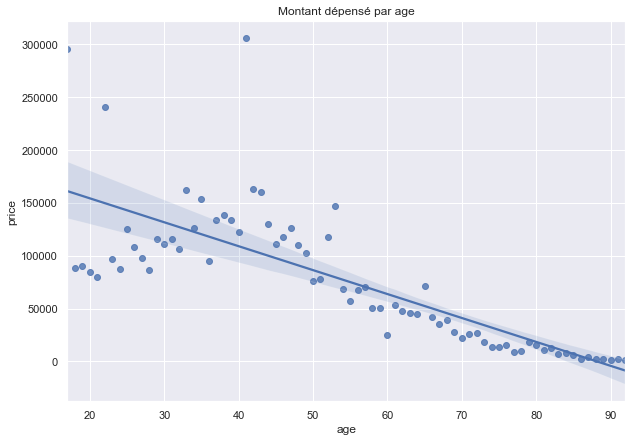

In [89]:
sns.regplot(x = 'age', y = price, data = montant_age).set(title = 'Montant dépensé par age')
plt.savefig('graphiques/P4_04_montant_depense_par_age_avec_outliers.png')

In [90]:
#On test la corrélation entre les variables en calculant le coefficient de pearson
corr_pearson = montant_age.corr(method = 'pearson')
corr_pearson

age     price
age    1.000000 -0.774658
price -0.774658  1.000000

In [91]:
#Détection des outliers gràce à la loi interquartile
q1 = montant_age[price].quantile(0.25)
q3 = montant_age[price].quantile(0.75)
iqr = q3 - q1

montant_age_min = q1 - 1.5 * iqr
montant_age_max = q3 + 1.5 * iqr
montant_age = montant_age[montant_age[price] < montant_age_max]

In [92]:
#On instancie le model
model_linReg = LinearRegression()
x = montant_age.iloc[:, 0].values
x = x.reshape(-1, 1)
y = montant_age.iloc[:, 1].values
y = y.reshape(-1, 1)
#entrainement du modèle
model_linReg.fit(x, y)
#précision du modèle
precision = model_linReg.score(x, y)
print(precision*100)

69.38007507852036


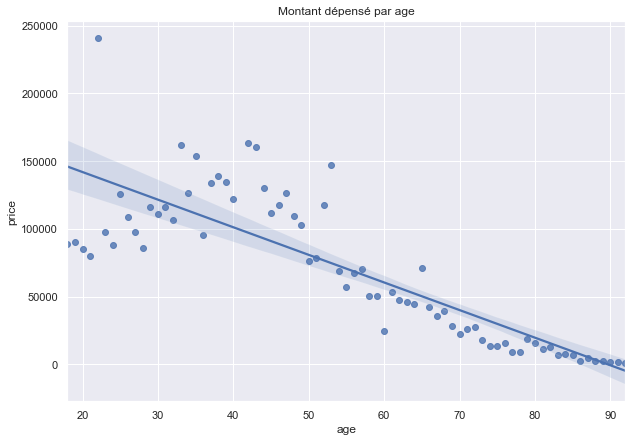

In [93]:
sns.regplot(x = 'age', y = price, data = montant_age).set(title = 'Montant dépensé par age')
plt.savefig('graphiques/P4_04_montant_depense_par_age_sans_outliers.png')

In [94]:
#On test la corrélation entre les variables en calculant le coefficient de pearson
corr_pearson = montant_age.corr(method = 'pearson')
corr_pearson

age     price
age    1.000000 -0.832947
price -0.832947  1.000000

#### sexe/catégorie

In [95]:
sex_cat = transactions.copy()
sex_cat = sex_cat[[sex, categ]].pivot_table(index = categ, columns = sex, aggfunc= len).fillna(0).copy().astype(int)
sex_cat

sex         f       m
categ                
0      103786  105640
1       55469   54266
2        8260    9292

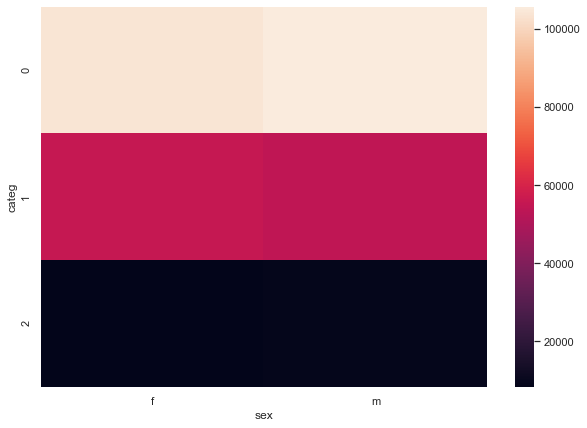

In [96]:
sns.heatmap(data = sex_cat)
plt.savefig('graphiques/P4_04_sexe_clients_par_categorie.png')

In [97]:
#Test chi2
st_chi2, st_p, st_dof, st_exp = st.chi2_contingency(sex_cat)

In [98]:
#Comparer à la table Khi2
st_chi2

81.86933350990711

In [99]:
st_dof

2

In [100]:
st_p

1.6683997257127539e-18

#### Age/fréquence d'achat

In [101]:
nb_achat_age = transactions.copy()

In [102]:
nb_achat_age = nb_achat_age[['age', client_id, session_id]].drop_duplicates()
nb_achat_age = nb_achat_age.groupby(['age', client_id]).count().reset_index()
nb_achat_age.head()

age client_id  session_id
0   17    c_1042           4
1   17    c_1046           7
2   17    c_1065          11
3   17    c_1088           5
4   17     c_109           4

In [103]:
nb_achat_age = nb_achat_age.groupby(['age']).mean(session_id).reset_index()
nb_achat_age = nb_achat_age.rename(columns = {session_id : "Fréquence d'achats"})
nb_achat_age.describe()

age  Fréquence d'achats
count  76.000000           76.000000
mean   54.500000           19.125289
std    22.083176            6.868029
min    17.000000            8.218543
25%    35.750000           16.420240
50%    54.500000           19.504274
75%    73.250000           22.615201
max    92.000000           52.895288

In [104]:
#On instancie le model
model_linReg = LinearRegression()
x = nb_achat_age.iloc[:, 0].values
x = x.reshape(-1, 1)
y = nb_achat_age.iloc[:, 1].values
y = y.reshape(-1, 1)
#entrainement du modèle
model_linReg.fit(x, y)
#précision du modèle
precision = model_linReg.score(x, y)
print(precision*100)

0.40085288436750854


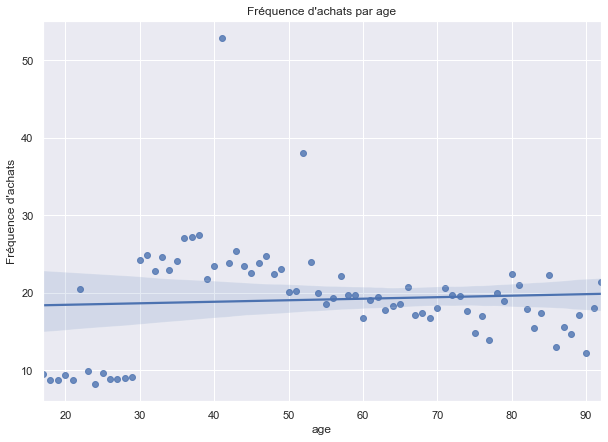

In [105]:
sns.regplot(x = 'age', y = "Fréquence d'achats", data = nb_achat_age).set(title = "Fréquence d'achats par age")
plt.savefig('graphiques/P4_04_frequence_achat_par_age_avec_outliers.png')

In [106]:
#On test la corrélation entre les variables en calculant le coefficient de pearson
corr_pearson = nb_achat_age.corr(method = 'pearson')
corr_pearson

age  Fréquence d'achats
age                 1.000000            0.063313
Fréquence d'achats  0.063313            1.000000

In [107]:
#Détection des outliers gràce à la loi interquartile
q1 = nb_achat_age["Fréquence d'achats"].quantile(0.25)
q3 = nb_achat_age["Fréquence d'achats"].quantile(0.75)
iqr = q3 - q1

nb_achat_age_min = q1 - 1.5 * iqr
nb_achat_age_max = q3 + 1.5 * iqr
nb_achat_age = nb_achat_age[nb_achat_age["Fréquence d'achats"] < nb_achat_age_max]
nb_achat_age = nb_achat_age[nb_achat_age["Fréquence d'achats"] > nb_achat_age_min]

In [108]:
#On instancie le model
model_linReg = LinearRegression()
x = nb_achat_age.iloc[:, 0].values
x = x.reshape(-1, 1)
y = nb_achat_age.iloc[:, 1].values
y = y.reshape(-1, 1)
#entrainement du modèle
model_linReg.fit(x, y)
#précision du modèle
precision = model_linReg.score(x, y)
print(precision*100)

2.0907605230549353


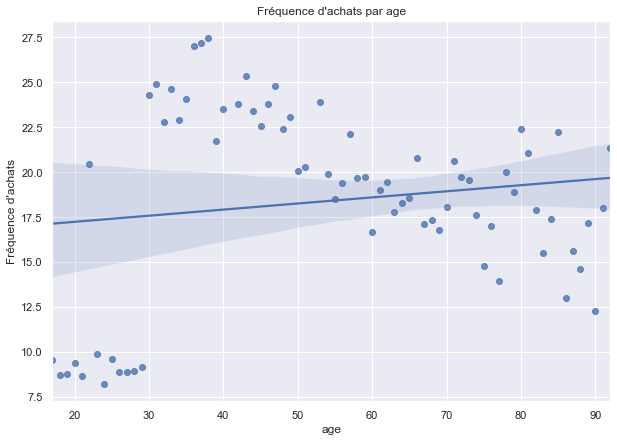

In [109]:
sns.regplot(x = 'age', y = "Fréquence d'achats", data = nb_achat_age).set(title = "Fréquence d'achats par age")
plt.savefig('graphiques/P4_04_frequence_achat_par_age_sans_outliers.png')

In [110]:
#On test la corrélation entre les variables en calculant le coefficient de pearson
corr_pearson = nb_achat_age.corr(method = 'pearson')
corr_pearson

age  Fréquence d'achats
age                 1.000000            0.144595
Fréquence d'achats  0.144595            1.000000

#### Age/taille du panier moyen

In [111]:
age_moy_achat = transactions.copy()
age_moy_achat = age_moy_achat[['age', client_id, session_id]]
age_moy_achat = age_moy_achat.groupby(['age', session_id]).count().reset_index()
age_moy_achat

age session_id  client_id
0        17   s_100056          1
1        17   s_100057          1
2        17   s_100084          1
3        17   s_100087          1
4        17   s_100148          1
...     ...        ...        ...
169168   92    s_83514          1
169169   92    s_87562          4
169170   92    s_92980          1
169171   92    s_95446          2
169172   92    s_95746          5

[169173 rows x 3 columns]

In [112]:
age_moy_achat = age_moy_achat.groupby('age').mean().reset_index()
age_moy_achat = age_moy_achat[['age', client_id]]
age_moy_achat= age_moy_achat.rename(columns = {client_id : "Taille du panier"})

In [113]:
#On instancie le model
model_linReg = LinearRegression()
x = age_moy_achat.iloc[:, 0].values
x = x.reshape(-1, 1)
y = age_moy_achat.iloc[:, 1].values
y = y.reshape(-1, 1)
#entrainement du modèle
model_linReg.fit(x, y)
#précision du modèle
precision = model_linReg.score(x, y)
print(precision*100)

33.72152729580793


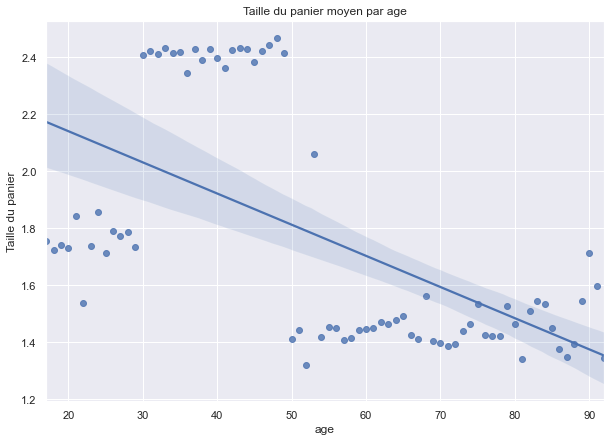

In [114]:
sns.regplot(x = 'age', y = "Taille du panier", data = age_moy_achat).set(title = 'Taille du panier moyen par age')
plt.savefig('graphiques/P4_04_taille_panier_moyen_par_age.png')

In [115]:
age_moy_achat.corr(method = 'pearson')

age  Taille du panier
age               1.000000         -0.580702
Taille du panier -0.580702          1.000000

#### Age/catégories de produits achetés

In [116]:
age_cat = transactions.copy()

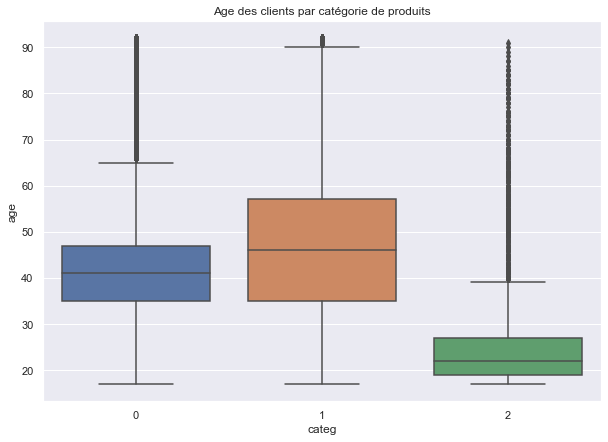

In [117]:
sns.boxplot(x = categ, y =  'age', data = age_cat).set(title = 'Age des clients par catégorie de produits')
plt.savefig('graphiques/P4_04_age_clients_par_categorie.png')

In [118]:
#Méthode des moindres carrés
X = categ # qualitative
Y = 'age' # quantitative

sous_echantillon = age_cat[age_cat['age'] > 0] # On ne garde que les categories 1 et 2

eta_squared(sous_echantillon[X],sous_echantillon[Y])

0.1188683230368311

In [119]:
st.f_oneway(age_cat['age'], age_cat[categ])

F_onewayResult(statistic=3357295.40160639, pvalue=0.0)